<a href="https://colab.research.google.com/github/rickyhugo/ERM/blob/vimo/CA5/CA5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx
from google.colab import drive
# import keras, tensorflow, gensim, h5py, nltk, sklearn, pickle

# plot styling
plt.style.use('seaborn-darkgrid') # style
plt.rcParams['font.family'] = ' DIN Alternate' # for macintosh use
# plt.rcParams['font.family'] =  'HP Simplified Jpan' # for windows use
plt.rcParams.update({'font.size': 13}) # font size
plt_dpi = None # resolution
USE_G_COLAB = False
if USE_G_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    os.chdir("/content/drive/My Drive/CA5")
    !ls

Mounted at /content/drive
CA5.ipynb  loan_data.csv


In [ ]:
# read data
credit_data = pd.read_csv('loan_data.csv')
credit_data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,22400,62354.0,88287.0,DebtCon,Office,3.0,NaN,NaN,163.056409,NaN,16.0,37.171396
1,1,10000,65000.0,80000.0,DebtCon,Other,2.0,0.0,0.0,26.366667,3.0,2.0,NaN
2,0,15400,100848.0,129454.0,HomeImp,ProfExe,10.0,0.0,0.0,174.896519,2.0,31.0,28.065591
3,0,8600,38646.0,54073.0,DebtCon,Other,14.0,0.0,0.0,89.555853,0.0,11.0,32.530257
4,0,27700,73148.0,101462.0,DebtCon,ProfExe,10.0,0.0,0.0,264.605389,0.0,33.0,40.475793


## 1. Explore data

For b-e), produce two bar plots, the first, a stacked bar plot, showing the percentages of non-
defaulted/defaulted customers for each feature value (which for REASON are ‘DebtCon’ and ‘HomeImp’), and 
the second, a regular bar plot, showing the number of customers corresponding to each value. 

a) What is the default probability in the whole data set? 

In [ ]:
# Extract the total probability of default on the data set
prob_default = np.mean(credit_data['BAD'].values)
prob_default

0.199496644295302

b) Type of job (JOB) 

findfont: Font family ['DIN Alternate'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DIN Alternate'] not found. Falling back to DejaVu Sans.


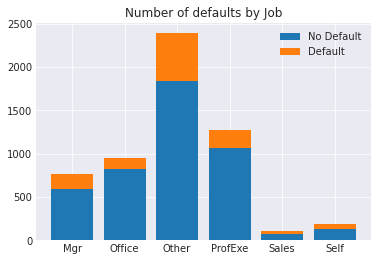

In [ ]:
# Aggregate number of defaults based on job type
agg_jobs_def = credit_data.groupby('JOB')['BAD'].sum()
agg_jobs_tot = credit_data.groupby('JOB')['BAD'].count()
agg_jobs_no_def = agg_jobs_tot - agg_jobs_def

fig, ax = plt.subplots()
# First plot the 'No Default' bars for every day.
ax.bar(agg_jobs_no_def.index, agg_jobs_no_def, label='No Default')
# Then plot the 'Female' bars on top, starting at the top of the 'Male'
# bars.
ax.bar(agg_jobs_def.index, agg_jobs_def, bottom=agg_jobs_no_def,
       label='Default')
ax.set_title('Number of defaults by Job')
ax.legend()
plt.show()

c) Reason for taking the loan (REASON) 

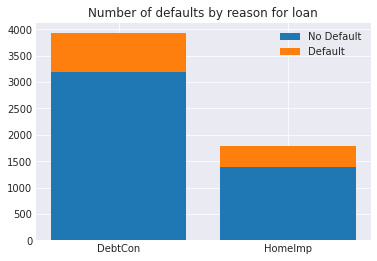

In [ ]:
# Aggregate number of defaults based on reason for loan 
agg_reason_def = credit_data.groupby('REASON')['BAD'].sum()
agg_reason_tot = credit_data.groupby('REASON')['BAD'].count()
agg_reason_no_def = agg_reason_tot - agg_reason_def

fig, ax = plt.subplots()
# First plot the 'No Default' bars for every day.
ax.bar(agg_reason_no_def.index, agg_reason_no_def, label='No Default')
# Then plot the 'Female' bars on top, starting at the top of the 'Male'
# bars.
ax.bar(agg_reason_def.index, agg_reason_def, bottom=agg_reason_no_def,
       label='Default')
ax.set_title('Number of defaults by reason for loan')
ax.legend()
plt.show()

d) Number of delinquent credit lines (DELINQ) 

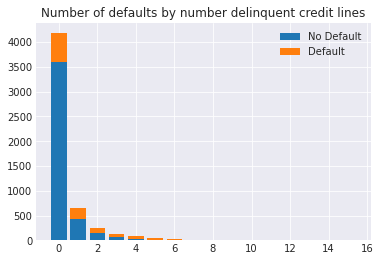

In [ ]:
# Aggregate number of defaults based on number delinquent credit lines
agg_num_def = credit_data.groupby('DELINQ')['BAD'].sum()
agg_num_tot = credit_data.groupby('DELINQ')['BAD'].count()
agg_num_no_def = agg_num_tot - agg_num_def

fig, ax = plt.subplots()
# First plot the 'No Default' bars for every day.
ax.bar(agg_num_no_def.index, agg_num_no_def, label='No Default')
# Then plot the 'Female' bars on top, starting at the top of the 'Male'
# bars.
ax.bar(agg_num_def.index, agg_num_def, bottom=agg_num_no_def,
       label='Default')
ax.set_title('Number of defaults by number delinquent credit lines')
ax.legend()
plt.show()

e) Number of major derogatory reports (DEROG) 

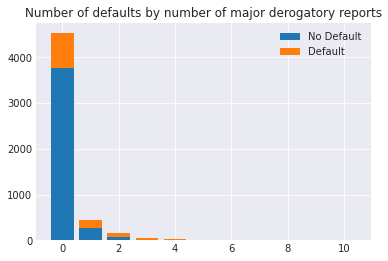

In [ ]:
# Aggregate number of defaults based on number of major derogatory reports
agg_rep_def = credit_data.groupby('DEROG')['BAD'].sum()
agg_rep_tot = credit_data.groupby('DEROG')['BAD'].count()
agg_rep_no_def = agg_rep_tot - agg_rep_def

fig, ax = plt.subplots()
# First plot the 'No Default' bars for every day.
ax.bar(agg_rep_no_def.index, agg_rep_no_def, label='No Default')
# Then plot the 'Defult' bars on top, starting at the top of the 'No Default'
# bars.
ax.bar(agg_rep_def.index, agg_rep_def, bottom=agg_rep_no_def,
       label='Default')
ax.set_title('Number of defaults by number of major derogatory reports')
ax.legend()
plt.show()

f) Calculate the correlation between all numerical columns (including BAD) and plot it as a heatmap 

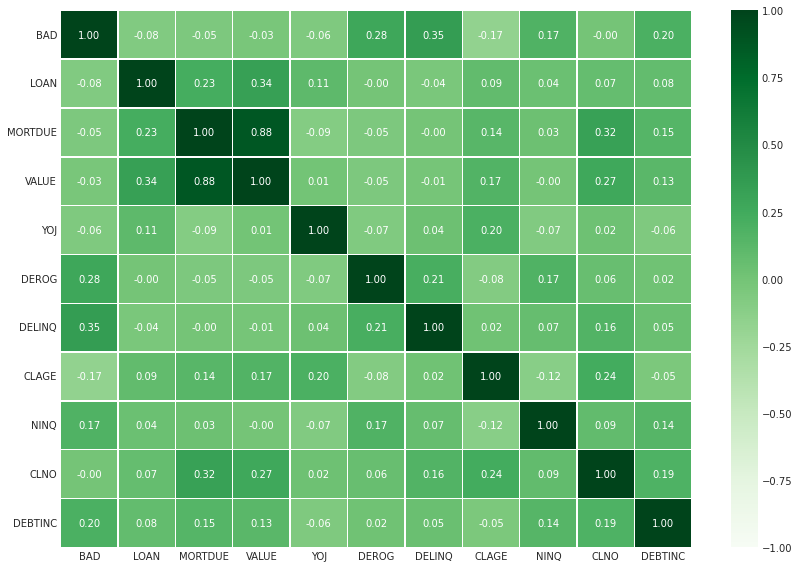

In [ ]:
corr_credit = credit_data.corr()

_, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['font.size'] = 10 # decrease font size
ax = sns.heatmap(
    corr_credit,
    vmin=-1,
    vmax=1,
    cmap='Greens',
    annot=True,
    fmt='.2f', 
    linewidths=.5,
    ax=ax,
    annot_kws={'color': 'white'}
)
ax.xaxis.set_tick_params(labelsize=10) # change tick label sizes
plt.tight_layout()

## 2. Preprocess data and split into training and test sets

a) Fill missing values: 

• For numerical columns (except YOJ, DEROG, DELINC, NINQ, CLNO): fill with the mean value of 
the column 

• For categorical columns and YOJ, DEROG, DELINC, NINQ, CLNO: fill with the most frequent value 

In [ ]:
# Continous variables 

# Extract all numerical parameters 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_parameters = credit_data.select_dtypes(include=numerics)


# Remove unwanted columns
not_good = ['YOJ', 'DEROG', 'DELINQ', 'NINQ', 'CLNO']
numerical_parameters = numerical_parameters.drop(not_good, axis=1)

# Replace nan:s with mean
column_means = numerical_parameters.mean()
numerical_parameters = numerical_parameters.fillna(column_means)

In [ ]:
# Categorical variables

# Extract variables that are not numerical (and the others)
all_cols = credit_data.columns
num_cols = numerical_parameters.columns
cate_cols = list(set(all_cols) - set(num_cols))

# Get date from these columsn
categorical_parameters = credit_data[cate_cols]

# Fill nans with most common value in that column
categorical_parameters = categorical_parameters.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [ ]:
# Merge the numerical data with the categorical and other data
frames = [numerical_parameters, categorical_parameters]

credit_data = pd.concat(frames, axis = 1)
credit_data

,BAD,LOAN,MORTDUE,VALUE,CLAGE,DEBTINC,CLNO,JOB,DELINQ,REASON,DEROG,YOJ,NINQ
0,0,22400,62354.0,88287.0,163.056409,37.171396,16.0,Office,0.0,DebtCon,0.0,3.0,0.0
1,1,10000,65000.0,80000.0,26.366667,33.779915,2.0,Other,0.0,DebtCon,0.0,2.0,3.0
2,0,15400,100848.0,129454.0,174.896519,28.065591,31.0,ProfExe,0.0,HomeImp,0.0,10.0,2.0
3,0,8600,38646.0,54073.0,89.555853,32.530257,11.0,Other,0.0,DebtCon,0.0,14.0,0.0
4,0,27700,73148.0,101462.0,264.605389,40.475793,33.0,ProfExe,0.0,DebtCon,0.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,28200,100353.0,131386.0,146.065483,38.679208,28.0,Office,0.0,DebtCon,0.0,9.0,0.0
5956,0,21200,91759.0,95165.0,106.835733,34.216689,19.0,ProfExe,0.0,DebtCon,0.0,2.0,0.0
5957,0,10600,82365.0,100272.0,122.483594,33.651647,26.0,ProfExe,0.0,DebtCon,1.0,3.0,0.0
5958,0,18200,68743.0,92112.0,95.343765,26.692667,16.0,Mgr,0.0,DebtCon,0.0,0.0,0.0


b) Create dummy variables for the categorical columns (REASON and JOB) 

In [ ]:
# Create dummy variables for Reason and Job (one)
reason = credit_data['REASON']
dummies_reason = pd.get_dummies(reason)
credit_data = credit_data.drop(['REASON'], axis = 1)
credit_data = credit_data.join(dummies_reason)

jobs = credit_data['JOB']
dummies_jobs = pd.get_dummies(jobs)
credit_data = credit_data.drop(['JOB'], axis = 1)
credit_data = credit_data.join(dummies_jobs)

,BAD,LOAN,MORTDUE,VALUE,CLAGE,DEBTINC,CLNO,DELINQ,DEROG,YOJ,NINQ,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,0,22400,62354.0,88287.0,163.056409,37.171396,16.0,0.0,0.0,3.0,0.0,1,0,0,1,0,0,0,0
1,1,10000,65000.0,80000.0,26.366667,33.779915,2.0,0.0,0.0,2.0,3.0,1,0,0,0,1,0,0,0
2,0,15400,100848.0,129454.0,174.896519,28.065591,31.0,0.0,0.0,10.0,2.0,0,1,0,0,0,1,0,0
3,0,8600,38646.0,54073.0,89.555853,32.530257,11.0,0.0,0.0,14.0,0.0,1,0,0,0,1,0,0,0
4,0,27700,73148.0,101462.0,264.605389,40.475793,33.0,0.0,0.0,10.0,0.0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,28200,100353.0,131386.0,146.065483,38.679208,28.0,0.0,0.0,9.0,0.0,1,0,0,1,0,0,0,0
5956,0,21200,91759.0,95165.0,106.835733,34.216689,19.0,0.0,0.0,2.0,0.0,1,0,0,0,0,1,0,0
5957,0,10600,82365.0,100272.0,122.483594,33.651647,26.0,0.0,1.0,3.0,0.0,1,0,0,0,0,1,0,0
5958,0,18200,68743.0,92112.0,95.343765,26.692667,16.0,0.0,0.0,0.0,0.0,1,0,1,0,0,0,0,0


c) Split the data into training and test sets by taking the first 4768 rows as training data and the rest as 
test data (an 80/20-split). Include the first 10 rows of each data set in the report. 

In [ ]:
idx = 4768
#Training data
train = credit_data.iloc[:idx,:]
#Test data
test = credit_data.iloc[idx:,:]

In [ ]:
train.head(10)

,BAD,LOAN,MORTDUE,VALUE,CLAGE,DEBTINC,CLNO,DELINQ,DEROG,YOJ,NINQ,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,0,22400,62354.0,88287.0,163.056409,37.171396,16.0,0.0,0.0,3.0,0.0,1,0,0,1,0,0,0,0
1,1,10000,65000.0,80000.0,26.366667,33.779915,2.0,0.0,0.0,2.0,3.0,1,0,0,0,1,0,0,0
2,0,15400,100848.0,129454.0,174.896519,28.065591,31.0,0.0,0.0,10.0,2.0,0,1,0,0,0,1,0,0
3,0,8600,38646.0,54073.0,89.555853,32.530257,11.0,0.0,0.0,14.0,0.0,1,0,0,0,1,0,0,0
4,0,27700,73148.0,101462.0,264.605389,40.475793,33.0,0.0,0.0,10.0,0.0,1,0,0,0,0,1,0,0
5,0,11300,78902.0,100332.0,116.998799,34.683071,26.0,0.0,0.0,4.0,0.0,1,0,0,0,0,1,0,0
6,0,8500,50569.0,60940.0,189.946898,29.202477,22.0,0.0,0.0,6.0,0.0,1,0,1,0,0,0,0,0
7,1,9000,32539.0,65440.0,179.766275,42.368944,16.0,0.0,0.0,5.0,0.0,0,1,0,1,0,0,0,0
8,0,12300,102908.0,124217.0,159.994026,27.707444,31.0,0.0,0.0,9.0,2.0,0,1,0,0,0,1,0,0
9,1,9100,78369.0,92000.0,180.833333,33.779915,35.0,0.0,0.0,0.2,3.0,1,0,0,0,0,0,1,0


In [ ]:
test.head(10)

,BAD,LOAN,MORTDUE,VALUE,CLAGE,DEBTINC,CLNO,DELINQ,DEROG,YOJ,NINQ,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
4768,0,11800,118053.0,125325.000000,181.172065,33.200397,18.0,0.0,0.0,5.0,0.0,1,0,0,0,0,0,0,1
4769,0,9200,19756.0,26140.000000,0.486711,27.075257,7.0,0.0,1.0,0.0,9.0,1,0,0,0,1,0,0,0
4770,1,18000,99401.0,140000.000000,150.100000,33.779915,20.0,0.0,2.0,8.9,3.0,1,0,0,0,1,0,0,0
4771,1,12900,46266.0,62000.000000,77.133333,33.779915,18.0,0.0,0.0,7.0,5.0,1,0,0,0,1,0,0,0
4772,0,28000,96015.0,127551.000000,196.523488,34.871643,37.0,0.0,1.0,0.0,3.0,1,0,0,0,0,1,0,0
4773,1,27000,124000.0,162000.000000,166.366667,33.779915,34.0,2.0,0.0,0.8,1.0,1,0,0,0,1,0,0,0
4774,1,10000,59929.0,101776.048741,179.766275,33.779915,16.0,0.0,0.0,5.0,0.0,1,0,0,0,1,0,0,0
4775,1,11000,53700.0,68000.000000,101.500000,33.779915,13.0,0.0,0.0,6.0,0.0,1,0,1,0,0,0,0,0
4776,0,25200,51789.0,75569.000000,281.928685,40.874619,30.0,1.0,0.0,25.0,1.0,1,0,0,0,1,0,0,0
4777,0,4200,66272.0,82953.000000,110.278663,43.450588,15.0,0.0,0.0,3.0,0.0,0,1,0,0,1,0,0,0


d) Create normalized versions of the training and test sets to be used for logistic regression and the 
neural networks. Do not normalize the dummy columns. Include the first 10 rows of each data set in 
the report. To normalize you should subtract the mean and divide by the standard deviation 
(StandardScaler in Sci-kit learn). Note that normalization of the test set is to be done using the means 
and standard deviations from the training set. 

In [ ]:
# Create scaler
scaler = sklearn.preprocessing.StandardScaler()

# Extract data to normalize 
data_scl = credit_data.iloc[:,1:11]
columns_scl = credit_data.iloc[:,1:11].columns
response = credit_data.iloc[:,0]

# Fit scaler to data
scaler.fit(data_scl)
scaled_data = scaler.transform(data_scl)

# Create dataframe from scaled data
credit_data_scl = pd.DataFrame(scaled_data, columns=columns_scl)

# Add dummy variables to data again
credit_data_scl = credit_data_scl.join(dummies_reason)
credit_data_scl = credit_data_scl.join(dummies_jobs)
credit_data_scl.insert(0, column='BAD', value='')
credit_data_scl['BAD'] = response

In [ ]:
# Split scaled data into train and test
idx = 4768
#Training data
train_scl = credit_data_scl.iloc[:idx,:]
#Test data
test_scl = credit_data_scl.iloc[idx:,:]

In [ ]:
train_scl.head(10)

,BAD,LOAN,MORTDUE,VALUE,CLAGE,DEBTINC,CLNO,DELINQ,DEROG,YOJ,NINQ,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,0,0.338377,-0.268536,-0.237320,-1.999839e-01,4.443721e-01,-0.509991,-0.375943,-0.280976,-0.672451,-0.643324,1,0,0,1,0,0,0,0
1,1,-0.768120,-0.206244,-0.383117,-1.835889e+00,9.309958e-16,-1.910288,-0.375943,-0.280976,-0.802991,1.136167,1,0,0,0,1,0,0,0
2,0,-0.286259,0.637678,0.486952,-5.828131e-02,-7.487251e-01,0.990328,-0.375943,-0.280976,0.241329,0.543003,0,1,0,0,0,1,0,0
3,0,-0.893047,-0.826662,-0.839264,-1.079640e+00,-1.637378e-01,-1.010097,-0.375943,-0.280976,0.763489,-0.643324,1,0,0,0,1,0,0,0
4,0,0.811315,-0.014427,-0.005525,1.015356e+00,8.773342e-01,1.190370,-0.375943,-0.280976,0.241329,-0.643324,1,0,0,0,0,1,0,0
5,0,-0.652117,0.121032,-0.025406,-7.512021e-01,1.183369e-01,0.490222,-0.375943,-0.280976,-0.541911,-0.643324,1,0,0,0,0,1,0,0
6,0,-0.901971,-0.545975,-0.718449,1.218418e-01,-5.997635e-01,0.090137,-0.375943,-0.280976,-0.280831,-0.643324,1,0,1,0,0,0,0,0
7,1,-0.857354,-0.970431,-0.639278,5.782574e-15,1.125386e+00,-0.509991,-0.375943,-0.280976,-0.411371,-0.643324,0,1,0,1,0,0,0,0
8,0,-0.562883,0.686174,0.394815,-2.366346e-01,-7.956517e-01,0.990328,-0.375943,-0.280976,0.110789,0.543003,0,1,0,0,0,1,0,0
9,1,-0.848430,0.108484,-0.171995,1.277057e-02,9.309958e-16,1.390413,-0.375943,-0.280976,-1.037963,1.136167,1,0,0,0,0,0,1,0


In [ ]:
test_scl.head(10)

,BAD,LOAN,MORTDUE,VALUE,CLAGE,DEBTINC,CLNO,DELINQ,DEROG,YOJ,NINQ,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
4768,0,-0.607500,1.042713,4.143086e-01,1.682451e-02,-7.593193e-02,-0.309948,-0.375943,-0.280976,-0.411371,-0.643324,1,0,0,0,0,0,0,1
4769,0,-0.839507,-1.271365,-1.330703e+00,-2.145620e+00,-8.784847e-01,-1.410182,-0.375943,0.971543,-1.064071,4.695147,1,0,0,0,1,0,0,0
4770,1,-0.054251,0.603613,6.724932e-01,-3.550464e-01,9.309958e-16,-0.109906,-0.375943,2.224062,0.097735,1.136167,1,0,0,0,1,0,0,0
4771,1,-0.509343,-0.647274,-6.998000e-01,-1.228313e+00,9.309958e-16,-0.309948,-0.375943,-0.280976,-0.150291,2.322494,1,0,0,0,1,0,0,0
4772,0,0.838085,0.523901,4.534717e-01,2.005506e-01,1.430447e-01,1.590455,-0.375943,0.971543,-1.064071,1.136167,1,0,0,0,0,1,0,0
4773,1,0.748851,1.182715,1.059550e+00,-1.603667e-01,9.309958e-16,1.290392,1.477341,-0.280976,-0.959639,-0.050160,1,0,0,0,1,0,0,0
4774,1,-0.768120,-0.325624,-2.560192e-16,5.782574e-15,9.309958e-16,-0.509991,-0.375943,-0.280976,-0.411371,-0.643324,1,0,0,0,1,0,0,0
4775,1,-0.678887,-0.472266,-5.942390e-01,-9.366919e-01,9.309958e-16,-0.810055,-0.375943,-0.280976,-0.280831,-0.643324,1,0,1,0,0,0,0,0
4776,0,0.588231,-0.517254,-4.610738e-01,1.222681e+00,9.295907e-01,0.890307,0.550699,-0.280976,2.199429,-0.050160,1,0,0,0,1,0,0,0
4777,0,-1.285675,-0.176299,-3.311634e-01,-8.316288e-01,1.267110e+00,-0.610012,-0.375943,-0.280976,-0.672451,-0.643324,0,1,0,0,1,0,0,0
